# Augmentacija podataka kod slika

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.models import load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import classification_report, accuracy_score
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
import cv2 as cv

## Učitavanje podataka

In [2]:
metadata_path = "metadata.csv"
images_path = "Images/Images/"

In [3]:
data = pd.read_csv(metadata_path)
data["path"] = data["filename"].map(lambda x:  os.path.join(images_path ,x))

In [4]:
print(data.head(10))

        filename  label                         path
0    dirty_2.jpg      1    Images/Images/dirty_2.jpg
1   clean_36.jpg      0   Images/Images/clean_36.jpg
2   clean_31.jpg      0   Images/Images/clean_31.jpg
3   dirty_69.jpg      1   Images/Images/dirty_69.jpg
4  clean_113.jpg      0  Images/Images/clean_113.jpg
5  clean_102.jpg      0  Images/Images/clean_102.jpg
6   clean_43.jpg      0   Images/Images/clean_43.jpg
7   dirty_27.jpg      1   Images/Images/dirty_27.jpg
8   dirty_53.jpg      1   Images/Images/dirty_53.jpg
9   clean_55.jpg      0   Images/Images/clean_55.jpg


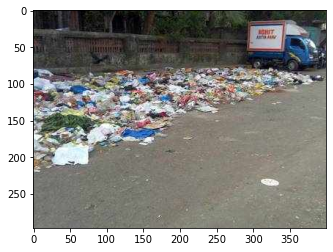

In [5]:
# Provera da li su putanje dobre.
image = plt.imread(data["path"][0])
plt.imshow(image)
plt.show()

In [6]:
# Konvertovanje labela u stringove - neophodno zbog ImageDataGenerator-a.
data["label"] = data["label"].astype(str)

## Podela podataka na trening i test dataset

In [7]:
data_test, data_train = train_test_split(data, test_size=0.8, random_state=7)

In [8]:
print(data_train.shape)
print(data_test.shape)

(190, 3)
(47, 3)


## Kreiranje modela koji će se koristiti

In [9]:
model=Sequential()

model.add(
    Conv2D(
        32, 
        (3, 3), 
        activation="relu", 
        padding='same',
        input_shape=(256, 256, 3),
        strides=1)
)

model.add(MaxPooling2D())

model.add(
    Conv2D(
        64,
        (2, 2),
        strides=2,
        activation="relu",
        padding='same')
)

model.add(MaxPooling2D())

model.add(
    Conv2D(
        128,
        (2, 2),
        strides=1,
        activation="relu",
        padding='same')
)

model.add(MaxPooling2D())

model.add(
    Conv2D(
        256,
        (2, 2),
        strides=1,
        activation="relu",
        padding='same')
)

model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dense(1, activation='sigmoid'))


In [10]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       32896     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 128)       0

## Treniranje i testiranje modela bez korišćenja augmentacija za dotreniravanje

Ovde će biti treniran model kod koga neće biti korišćene augmentacije podataka. Jedina transformacija koja će biti izvršena na slikama je reskaliranje na odgovarajuću veličinu za mrežu, i reskaliranje vrednosti boja piksela na opseg [0, 1].

In [11]:
batch_size = 32
image_size = 256

In [12]:
no_aug_generator = ImageDataGenerator(rescale = 1/255.)

In [13]:
no_aug_train_data = no_aug_generator.flow_from_dataframe(
    data_train, 
    target_size=(image_size, image_size), 
    x_col="path",
    y_col="label",
    batch_size=batch_size,
    class_mode="binary"
)

Found 190 validated image filenames belonging to 2 classes.


In [14]:
no_aug_test_data = no_aug_generator.flow_from_dataframe(
    data_test, 
    target_size=(image_size, image_size), 
    x_col="path",
    y_col="label",
    batch_size=batch_size,
    class_mode="binary"
)

Found 47 validated image filenames belonging to 2 classes.


In [15]:
checkpoint = ModelCheckpoint(
    "best_model_no_aug.h5", 
    monitor="loss", 
    mode="min", 
    verbose=1, 
    save_best_only=True
)

no_aug_model = Sequential.from_config(model.get_config())
no_aug_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.002), loss = "binary_crossentropy", metrics =["accuracy"])
no_aug_history = no_aug_model.fit(no_aug_train_data, steps_per_epoch=no_aug_train_data.samples // batch_size, epochs=50,  callbacks=[checkpoint])

Epoch 1/50


5/5 [==============================] - ETA: 0s - loss: 1.3599 - accuracy: 0.4937
Epoch 1: loss improved from inf to 1.35987, saving model to best_model_no_aug.h5
5/5 [==============================] - 4s 496ms/step - loss: 1.3599 - accuracy: 0.4937
Epoch 2/50


C:\Users\andje\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - ETA: 0s - loss: 0.6888 - accuracy: 0.5380
Epoch 2: loss improved from 1.35987 to 0.68876, saving model to best_model_no_aug.h5
5/5 [==============================] - 3s 485ms/step - loss: 0.6888 - accuracy: 0.5380
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 0.6637 - accuracy: 0.5316
Epoch 3: loss improved from 0.68876 to 0.66369, saving model to best_model_no_aug.h5
5/5 [==============================] - 3s 515ms/step - loss: 0.6637 - accuracy: 0.5316
Epoch 4/50
5/5 [==============================] - ETA: 0s - loss: 0.6417 - accuracy: 0.7152
Epoch 4: loss improved from 0.66369 to 0.64171, saving model to best_model_no_aug.h5
5/5 [==============================] - 3s 512ms/step - loss: 0.6417 - accuracy: 0.7152
Epoch 5/50
5/5 [==============================] - ETA: 0s - loss: 0.4739 - accuracy: 0.8062
Epoch 5: loss improved from 0.64171 to 0.47393, saving model to best_model_no_aug.h5
5/5 [==============================] - 3s 

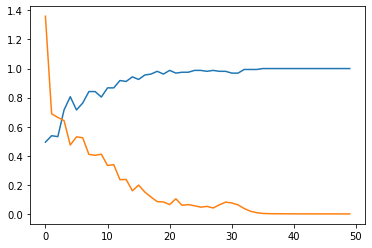

In [16]:
plt.plot(no_aug_history.history["accuracy"])
plt.plot(no_aug_history.history["loss"])

In [17]:
no_aug_test_labels = no_aug_test_data.classes

no_aug_model = load_model("best_model_no_aug.h5")

no_aug_predicted_probs = no_aug_model.predict(no_aug_test_data)
no_aug_predicted_labels = no_aug_predicted_probs.copy()

no_aug_predicted_labels[no_aug_predicted_probs < 0.5] = 0
no_aug_predicted_labels[no_aug_predicted_probs >= 0.5] = 1

2/2 [==============================] - 1s 208ms/step


In [18]:
print(classification_report(
    no_aug_test_labels,
    no_aug_predicted_labels,
    target_names=["Clean", "Dirty"]
    )
)

print("Accuracy: ", accuracy_score(no_aug_test_labels, no_aug_predicted_labels))

              precision    recall  f1-score   support

       Clean       0.38      0.36      0.37        22
       Dirty       0.46      0.48      0.47        25

    accuracy                           0.43        47
   macro avg       0.42      0.42      0.42        47
weighted avg       0.42      0.43      0.42        47

Accuracy:  0.425531914893617


## Treniranje i testiranje modela uz korišćenje augmentacija podataka

In [19]:
#Definisanje funkcija koje nisu dostupne u ImageDataGeneratoru i nasumično biranje neke od njih ili ni jedne, pri čemu su veće šanse da se ne desi ni jedna.

#Gausov šum
def gaussian_noise(image:np.ndarray) -> np.ndarray:
    row, col, ch = image.shape
    mean = 0
    var = 10
    sigma = var ** 0.5

    gauss = np.random.normal(mean, sigma, (row, col, ch))
    gauss = gauss.reshape(row, col, ch)

    noisy_image = image.astype(np.float64).copy()
    noisy_image = noisy_image + gauss.copy()
    noisy_image = np.clip(noisy_image, 0, 255)
    noisy_image.flags.writeable = True
    noisy_image.setflags(write=True)

    return noisy_image

#So i biber šum
def salt_n_pepper_noise(image:np.ndarray) -> np.ndarray:
    noisy_image = np.copy(image)

    num_salt = np.ceil(0.01 * image.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    noisy_image[coords[0], coords[1], :] = 255

    num_pepper = np.ceil(0.01 * image.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    noisy_image[coords[0], coords[1], :] = 0
    noisy_image.flags.writeable = True
    noisy_image.setflags(write=True)

    return noisy_image

#Tačkasti šum
def speckle_noise(image:np.ndarray) -> np.ndarray:
    gauss = np.random.normal(0, 0.5, image.shape)
    gauss = gauss + 1.0

    noisy_image = image.astype(np.float64) * gauss
    noisy_image = np.clip(noisy_image, 0, 255)
    noisy_image = noisy_image.copy()
    noisy_image.flags.writeable = True
    noisy_image.setflags(write=True)

    return noisy_image

#Primena nekog šuma
def add_noise(image:np.ndarray) -> np.ndarray:
    num = np.random.randint(0, 7)

    if num == 0:
        return gaussian_noise(image)
    elif num == 1:
        return salt_n_pepper_noise(image)
    elif num == 2:
        return speckle_noise(image)
    else:
        return image.copy()
    

In [20]:
#Isecanje
def random_cutout(image:np.ndarray, cutout_width_min:int, cutout_width_max:int, cutout_height_min:int, cutout_height_max:int) -> np.ndarray:
    width = np.random.randint(cutout_width_min, cutout_width_max + 1)
    height = np.random.randint(cutout_height_min, cutout_height_max + 1)

    start_x = np.random.randint(0, image.shape[1])
    start_y = np.random.randint(0, image.shape[0])

    modified_image = image.copy()
    modified_image[start_y:np.min([start_y + height, image.shape[0]]), start_x:np.min([start_x + width, image.shape[1]]), :] = 0
    modified_image.flags.writeable = True
    modified_image.setflags(write=True)

    return modified_image

#Sakrivanje delova
def hide_and_seek(image:np.ndarray, num_x:int, num_y:int, num_to_hide:int) -> np.ndarray:
    width = image.shape[1] // num_x
    height = image.shape[0] // num_y

    partial_image = image.copy()

    for i in range(num_to_hide):
        x = np.random.randint(0, num_x)
        y = np.random.randint(0, num_y)

        partial_image[y:y + height, x:x + width, :] = 0

    partial_image.flags.writeable = True
    partial_image.setflags(write=True)

    return partial_image

#Grid maska
def grid_mask(image:np.ndarray) -> np.ndarray:
    grid_mask = np.ones(image.shape).astype(np.uint8)
    
    for i in range(0, image.shape[0], 200):
        for j in range(0, image.shape[1], 200):
            grid_mask[i:i + 50, j:j + 50, :] = 0

    grid_mask = cv.resize(image, (int(image.shape[0] * (np.random.random() + 1)), int(image.shape[1] * (np.random.random() + 1))), interpolation=cv.INTER_AREA)[:image.shape[0], :image.shape[1]]

    resulting_image = image * grid_mask
    resulting_image = np.clip(resulting_image, 0, 255).copy()
    resulting_image.flags.writeable = True
    resulting_image.setflags(write=True)

    return resulting_image

#Primena nekog brisanja podataka
def delete_image_part(image:np.ndarray) -> np.ndarray:
    num = np.random.randint(0, 7)

    if num == 0:
        return random_cutout(image, 50, 100, 50, 100)
    elif num == 1:
        return hide_and_seek(image, 5, 4, 3)
    elif num == 2:
        return grid_mask(image)
    else:
        return image.copy()

In [21]:
#Sobel filter
def sobel_filter(image:np.ndarray) -> np.ndarray:
    grayscale_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY).astype(np.float64)

    sobelx = cv.Sobel(grayscale_image, cv.CV_64F, 1, 0, ksize=3)
    sobely = cv.Sobel(grayscale_image, cv.CV_64F, 0, 1, ksize=3)

    magnitude = cv.sqrt(cv.pow(sobelx, 2) + cv.pow(sobely, 2))
    magnitude = np.clip(magnitude, 0, 255).astype(np.uint8)
    
    sobel_combined = cv.cvtColor(magnitude, cv.COLOR_GRAY2BGR).astype(np.float64)
    sobel_combined = sobel_combined.copy()
    sobel_combined.flags.writeable = True
    sobel_combined.setflags(write=True)

    return sobel_combined

#Gaussian filter
def gaussian_filter(image:np.ndarray) -> np.ndarray:
    blurred_image = cv.GaussianBlur(image, (5, 5), 0)
    blurred_image = np.clip(blurred_image, 0, 255)
    blurred_image = blurred_image.copy()
    blurred_image.flags.writeable = True
    blurred_image.setflags(write=True)

    return blurred_image

def apply_filter(image:np.ndarray) -> np.ndarray:
    num = np.random.randint(0, 10)

    if num == 0:
        return sobel_filter(image)
    elif num == 1:
        return gaussian_filter(image)
    else:
        return image.copy()

In [22]:
def apply_some_augmentation(img:np.ndarray) -> np.ndarray:
    num = np.random.randint(0, 7)

    if num == 0:
        return add_noise(img)
    elif num == 1:
        return delete_image_part(img)
    elif num == 2:
        return apply_filter(img)
    else:
        return img

In [23]:
aug_train_generator = ImageDataGenerator(rescale=1/255,
                                         rotation_range=10,
                                         horizontal_flip=True,
                                         zoom_range=[0.5, 2],
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         brightness_range=[0.5, 1.5],
                                         channel_shift_range=10,
                                         preprocessing_function=apply_some_augmentation
)

aug_test_generator = ImageDataGenerator(rescale=1/255)

In [24]:
aug_train_data = aug_train_generator.flow_from_dataframe(
    data_train, 
    target_size=(image_size, image_size), 
    x_col="path",
    y_col="label",
    batch_size=batch_size,
    class_mode="binary"
)

Found 190 validated image filenames belonging to 2 classes.


In [25]:
aug_test_data = aug_test_generator.flow_from_dataframe(
    data_test, 
    target_size=(image_size, image_size), 
    x_col="path",
    y_col="label",
    batch_size=batch_size,
    class_mode="binary"
)

Found 47 validated image filenames belonging to 2 classes.


In [26]:
checkpoint = ModelCheckpoint(
    "best_model_aug.h5", 
    monitor="loss", 
    mode="min", 
    verbose=1, 
    save_best_only=True
)

aug_model = Sequential.from_config(model.get_config())
aug_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.002), loss = "binary_crossentropy", metrics =["accuracy"])
aug_history = aug_model.fit(aug_train_data, steps_per_epoch=aug_train_data.samples // batch_size, epochs=50, callbacks=[checkpoint])

Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 1.1057 - accuracy: 0.4875
Epoch 1: loss improved from inf to 1.10567, saving model to best_model_aug.h5
5/5 [==============================] - 6s 943ms/step - loss: 1.1057 - accuracy: 0.4875


C:\Users\andje\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 0.6987 - accuracy: 0.5570
Epoch 2: loss improved from 1.10567 to 0.69870, saving model to best_model_aug.h5
5/5 [==============================] - 5s 901ms/step - loss: 0.6987 - accuracy: 0.5570
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 0.6705 - accuracy: 0.5253
Epoch 3: loss improved from 0.69870 to 0.67047, saving model to best_model_aug.h5
5/5 [==============================] - 5s 843ms/step - loss: 0.6705 - accuracy: 0.5253
Epoch 4/50
5/5 [==============================] - ETA: 0s - loss: 0.6997 - accuracy: 0.5570
Epoch 4: loss did not improve from 0.67047
5/5 [==============================] - 4s 844ms/step - loss: 0.6997 - accuracy: 0.5570
Epoch 5/50
5/5 [==============================] - ETA: 0s - loss: 0.6781 - accuracy: 0.6013
Epoch 5: loss did not improve from 0.67047
5/5 [==============================] - 5s 832ms/step - loss: 0.6781 - accuracy: 0.6013
Epoch 6/50
5/5 [==================

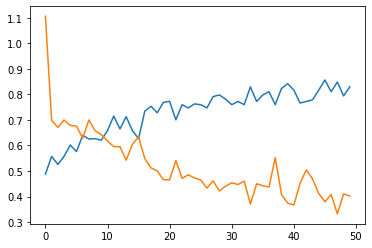

In [27]:
plt.plot(aug_history.history["accuracy"])
plt.plot(aug_history.history["loss"])

In [28]:
aug_test_labels = aug_test_data.classes

aug_model = load_model("best_model_aug.h5")

aug_predicted_probs = aug_model.predict(aug_test_data)
aug_predicted_labels = aug_predicted_probs.copy()

aug_predicted_labels[aug_predicted_probs < 0.5] = 0
aug_predicted_labels[aug_predicted_probs >= 0.5] = 1

2/2 [==============================] - 1s 81ms/step


In [29]:
print(classification_report(
    aug_test_labels,
    aug_predicted_labels,
    target_names=["Clean", "Dirty"]
    )
)

print("Accuracy: ", accuracy_score(aug_test_labels, aug_predicted_labels))

              precision    recall  f1-score   support

       Clean       0.56      0.45      0.50        22
       Dirty       0.59      0.68      0.63        25

    accuracy                           0.57        47
   macro avg       0.57      0.57      0.56        47
weighted avg       0.57      0.57      0.57        47

Accuracy:  0.574468085106383


Možemo primetiti da je, dodavanjem augmentacija u treniranje modela, tačnost modela povećana čak za gotovo 15%. Naravno, uz bolje kreiranje samog modela, ova brojka može biti i veća.